In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.extra_torch_modules import Bias
from janelia_core.ml.latent_regression import LatentRegModel
from janelia_core.ml.latent_regression import LinearMap
from janelia_core.ml.latent_regression import IdentityMap
from janelia_core.visualization.matrix_visualization import cmp_n_mats

## Parameters for model go here

In [3]:
d_in = [100, 100]
d_out = [1000, 1000]

d_proj = [2, 2]
d_trans = [2, 2]

n_smps = 10000

In [4]:
## Create the model here
n_output_groups = len(d_in)

#M = LinearMap(d_proj, d_trans)
M = IdentityMap()
S = [Bias(d_o) for d_o in d_out]
mdl = LatentRegModel(d_in, d_out, d_proj, d_trans, M, S, direct_pairs=None, w_gain=50, 
                    noise_range=[50.0, 100.0])

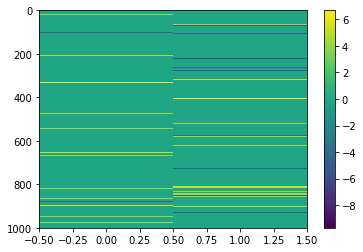

In [5]:
## Modify u[0] to make it sparse
u_orig = mdl.u[0].detach().numpy()
u_orig[np.abs(u_orig) < 4] = 0
plt.imshow(u_orig, aspect='auto')
plt.colorbar()

## Generate some x data here

In [6]:
x = [torch.randn([n_smps, d]) for d in d_in]

## Run the model forward 

In [7]:
y_pred = mdl(x)
y = mdl.generate(x)

## Fit a new model

In [8]:
M_fitted = IdentityMap()
#M_fitted = LinearMap(d_proj, d_trans)
S_fitted = [Bias(d_o) for d_o in d_out]
fitted_mdl = LatentRegModel(d_in, d_out, d_proj, d_trans, M_fitted, S_fitted, direct_pairs=None)

## Move model to cuda

In [9]:
fitted_mdl=fitted_mdl.cuda()
x = [x_i.pin_memory() for x_i in x]
y = [y_i.pin_memory() for y_i in y]

In [10]:
log = fitted_mdl.fit(x, y, max_its=10000, batch_size=10, send_size=10, update_int=1000, min_var = .01,
                     learning_rates=.1, l1_u_lambda = [1000., 0])

0: Elapsed fitting time 0.0, vl: 186983950.0, lr: 0.1
1000: Elapsed fitting time 10.77193021774292, vl: 37610.035, lr: 0.1
2000: Elapsed fitting time 20.488402843475342, vl: 69591.31, lr: 0.1
3000: Elapsed fitting time 30.247493982315063, vl: 59475.89, lr: 0.1
4000: Elapsed fitting time 39.917879819869995, vl: 32767.846, lr: 0.1
5000: Elapsed fitting time 49.455432176589966, vl: 29747.02, lr: 0.1
6000: Elapsed fitting time 59.43026065826416, vl: 31512.523, lr: 0.1
7000: Elapsed fitting time 69.03356170654297, vl: 22980.82, lr: 0.1
8000: Elapsed fitting time 78.49993562698364, vl: 27518.596, lr: 0.1


KeyboardInterrupt: 

In [11]:
%matplotlib qt
plt.figure()
plt.plot(log['elapsed_time'], log['obj'])

NameError: name 'log' is not defined

## Compare predictions from fitted model to ground truth

In [12]:
fitted_mdl = fitted_mdl.to('cpu')
x = [x_g.to('cpu') for x_g in x]
y = [y_h.to('cpu') for y_h in y]

plt_smps = np.arange(1000)

%matplotlib qt
true_y_hat = mdl(x)
fitted_y_hat = fitted_mdl(x)

for g in range(n_output_groups):
    plt.figure()
    for d in range(5):
        plt.subplot(1, 5, d+1)
        true_obs_values = y[g][plt_smps, d].detach().numpy()
        true_plt_values = true_y_hat[g][plt_smps, d].detach().numpy()
        fitted_plt_values = fitted_y_hat[g][plt_smps, d].detach().numpy()
        plt.plot(true_obs_values, 'go')
        plt.plot(true_plt_values, 'ro')
        plt.plot(fitted_plt_values, 'b-')

## Visualize parameters

In [ ]:
u_est = u_h = np.abs(fitted_mdl.u[0].detach().cpu().numpy())
u_true = u_h = np.abs(mdl.u[0].detach().cpu().numpy())

In [ ]:
plt.figure()
cmp_n_mats([u_est, u_true, u_est - u_true], titles=['Estimated', 'True', 'Diff'])

In [ ]:
print(cmp_n_mats.__doc__)